## Markov Model of a Three-Tank Duel

In [2]:
import numpy as np
import pandas as pd
from numpy.linalg import inv

# Define all possible states
states = [
    (1, 1, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1),
    (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 0, 0)
]
state_index = {state: i for i, state in enumerate(states)}
n_states = len(states)
P = np.zeros((n_states, n_states))  # Transition matrix

# Hit probabilities
hit_probs = {'A': 2/3, 'B': 1/2, 'C': 1/4}
absorbing = {(1,0,0), (0,1,0), (0,0,1), (0,0,0)}

def add_transition(from_state, to_state, prob):
    i = state_index[from_state]
    j = state_index[to_state]
    P[i, j] += prob

# Transitions from state (1,1,1)
add_transition((1,1,1), (1,0,1), hit_probs['A'] * 0.5)
add_transition((1,1,1), (1,1,0), hit_probs['A'] * 0.5)
add_transition((1,1,1), (0,1,1), (1-hit_probs['A']) * hit_probs['B'] * 0.5)
add_transition((1,1,1), (1,1,0), (1-hit_probs['A']) * hit_probs['B'] * 0.5)
add_transition((1,1,1), (0,1,1), (1-hit_probs['A']) * (1-hit_probs['B']) * hit_probs['C'] * 0.5)
add_transition((1,1,1), (1,0,1), (1-hit_probs['A']) * (1-hit_probs['B']) * hit_probs['C'] * 0.5)
add_transition((1,1,1), (1,1,1), (1-hit_probs['A']) * (1-hit_probs['B']) * (1-hit_probs['C']))

# Two-tank scenarios
# (A vs B)
P[state_index[(1,1,0)], state_index[(1,0,0)]] = hit_probs['A'] * 0.5
P[state_index[(1,1,0)], state_index[(0,1,0)]] = (1-hit_probs['A']) * hit_probs['B'] * 0.5
P[state_index[(1,1,0)], state_index[(1,1,0)]] = (1-hit_probs['A']) * (1-hit_probs['B'])

# (A vs C)
P[state_index[(1,0,1)], state_index[(1,0,0)]] = hit_probs['A'] * 0.5
P[state_index[(1,0,1)], state_index[(0,0,1)]] = (1-hit_probs['A']) * hit_probs['C'] * 0.5
P[state_index[(1,0,1)], state_index[(1,0,1)]] = (1-hit_probs['A']) * (1-hit_probs['C'])

# (B vs C)
P[state_index[(0,1,1)], state_index[(0,1,0)]] = hit_probs['B'] * 0.5
P[state_index[(0,1,1)], state_index[(0,0,1)]] = (1-hit_probs['B']) * hit_probs['C'] * 0.5
P[state_index[(0,1,1)], state_index[(0,1,1)]] = (1-hit_probs['B']) * (1-hit_probs['C'])

# Absorbing states
for s in absorbing:
    P[state_index[s], state_index[s]] = 1

# Transient and absorbing state indices
absorbing_indices = [state_index[s] for s in absorbing]
transient_indices = [i for i in range(n_states) if i not in absorbing_indices]

# Submatrices Q and R
Q = P[np.ix_(transient_indices, transient_indices)]
R = P[np.ix_(transient_indices, absorbing_indices)]

# Fundamental matrix
N = inv(np.eye(len(Q)) - Q)

# Expected duration from each transient state
expected_steps = N @ np.ones((len(Q), 1))

# Absorption probabilities
B = N @ R

# Create dataframes for visualization
df_expected_steps = pd.DataFrame(expected_steps, index=[str(states[i]) for i in transient_indices], columns=["Expected Steps"])
df_absorption_probs = pd.DataFrame(B, index=[str(states[i]) for i in transient_indices], columns=[str(states[i]) for i in absorbing_indices])

# Combine for final display
result_df = pd.concat([df_expected_steps, df_absorption_probs], axis=1)
print(result_df)

           Expected Steps  (1, 0, 0)  (0, 0, 0)  (0, 0, 1)  (0, 1, 0)
(1, 1, 1)        2.444444   0.370370        0.0   0.034392   0.095238
(1, 1, 0)        1.200000   0.400000        0.0   0.000000   0.100000
(1, 0, 1)        1.333333   0.444444        0.0   0.055556   0.000000
(0, 1, 1)        1.600000   0.000000        0.0   0.100000   0.400000


## Graph Visualization

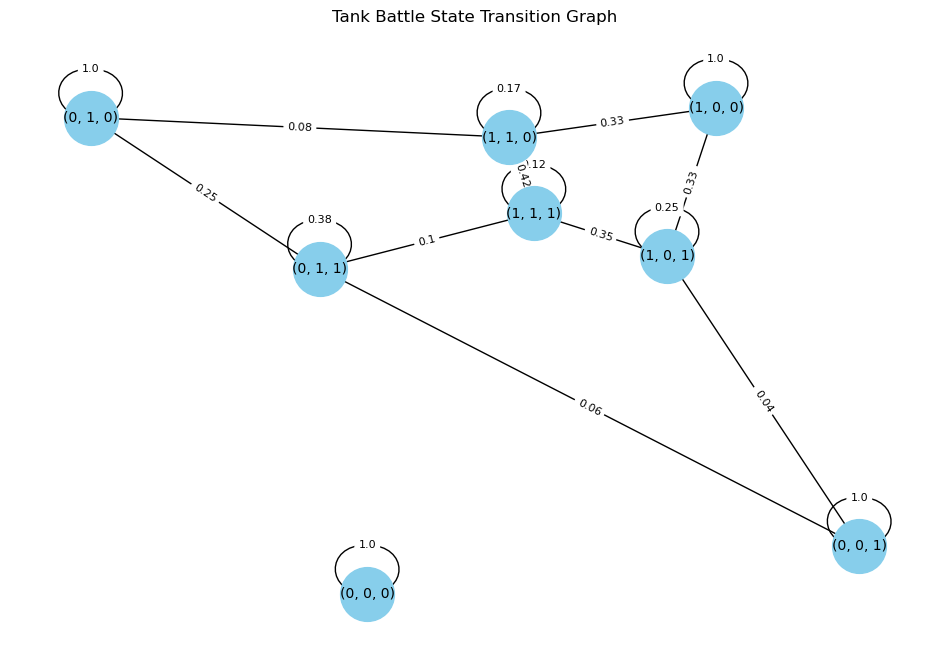

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add edges with weights from the transition matrix for non-zero transitions
for i, from_state in enumerate(states):
    for j, to_state in enumerate(states):
        prob = P[i, j]
        if prob > 0.01:  # Only show significant transitions
            G.add_edge(str(from_state), str(to_state), weight=round(prob, 2))

# Set positions using spring layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edges with weights
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->')
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Tank Battle State Transition Graph")
plt.axis('off')
plt.show()